In [1]:
import yfinance as yf
from pandas_datareader import data
import numpy as np
import pandas as pd
import pylab as plt


yf.pdr_override()


In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


In [3]:
window_size = 20
startdate = '2012-01-01'
enddate = '2022-12-31'
HSI_list = ['0001.HK', '0002.HK', '0003.HK', '0005.HK', '0006.HK', '0011.HK', '0012.HK', '0016.HK', '0017.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0288.HK', '0291.HK', '0316.HK', '0322.HK', '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK', '0992.HK', '1038.HK', '1044.HK',
            '1088.HK', '1093.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK', '1929.HK', '1997.HK', '2007.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '3690.HK', '3692.HK', '3968.HK', '3988.HK', '6098.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9988.HK', '9999.HK']

raw_data = None

for i in HSI_list:
    # fetch data through yahoo finance
    stockdata_close = data.get_data_yahoo(tickers=i, start=startdate, end=enddate)['Close']

    if raw_data is None:
        raw_data = scaler.fit_transform(np.array(stockdata_close).reshape(-1, 1))
    else:
        ranks = scaler.fit_transform(np.array(stockdata_close).reshape(-1, 1))
        # skip data with NaN
        if len(ranks) != raw_data.shape[0]:
            continue
        raw_data = np.hstack((raw_data, ranks))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
raw_data.shape

(2712, 58)

In [5]:
train_ratio = 0.7
train_size = int(train_ratio*len(raw_data))
train_data, test_data = raw_data[:train_size], raw_data[train_size:]


[*********************100%***********************]  1 of 1 completed


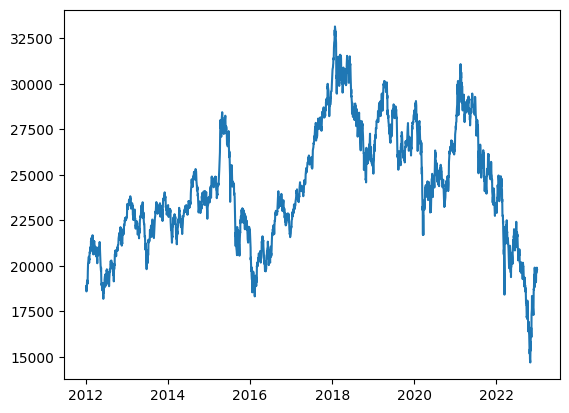

In [6]:
hsi_data = data.get_data_yahoo(
    tickers='^HSI', start=startdate, end=enddate)['Close']
plt.plot(hsi_data)


In [7]:
hsi_test = hsi_data[-len(test_data):]
hsi_test.shape

(814,)

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator


def get_x_y_timeseries(original, window_len):
    og = TimeseriesGenerator(
        original, original, length=window_len, batch_size=len(original))
    return list(og)[0][0], list(og)[0][1]


In [9]:
from keras.preprocessing.sequence import TimeseriesGenerator

x_all, y_all = get_x_y_timeseries(raw_data, window_size)

x_train, y_train = get_x_y_timeseries(train_data, window_size)
x_test, y_test = get_x_y_timeseries(test_data, window_size)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 58)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(58))
model.compile(loss='mean_squared_error', optimizer='adam')


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            21800     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 58)                2958      
                                                                 
Total params: 65,158
Trainable params: 65,158
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=50, batch_size=64, verbose=True)


Epoch 1/50
30/30 [==============================] - 4s 40ms/step - loss: 0.0764 - val_loss: 0.1297
Epoch 2/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0162 - val_loss: 0.1048
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0089 - val_loss: 0.0973
Epoch 4/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0065 - val_loss: 0.0921
Epoch 5/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0050 - val_loss: 0.0886
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0041 - val_loss: 0.0849
Epoch 7/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0035 - val_loss: 0.0820
Epoch 8/50
30/30 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.0815
Epoch 9/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0027 - val_loss: 0.0799
Epoch 10/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 0.0800
Epoch 11/

In [14]:
y_predict = scaler.inverse_transform(model.predict(x_test))
y_test = scaler.inverse_transform(y_test)
# hsi_predict = scaler.inverse_transform(model.predict(hsi_x))


25/25 [==============================] - 1s 3ms/step


In [15]:
buy_factor, sell_factor = 12, 6
return_value = 1
hsi_value = 1
# hold_stocks stores (stock_index, buyin_price)
returns = [return_value]
hsi_return = [hsi_value]
for i in range(len(y_predict) - 1):
    prediction = y_predict[i + 1] - y_test[i]
    ranks = np.argsort(prediction)

    factor = 0

    # sell 6 worst stocks
    for j in ranks[:sell_factor]:
        factor += (y_test[i][j] - y_test[i + 1][j]) / y_test[i][j]

    # buy 12 best stocks
    for j in ranks[-buy_factor:]:
        factor += (y_test[i + 1][j] - y_test[i][j]) / y_test[i][j]

    return_value *= 1 + factor / (buy_factor + sell_factor)
    hsi_value *= hsi_test[i + 1] / hsi_test[i]
    returns.append(return_value)
    hsi_return.append(hsi_value)

print('return: ', return_value * 100, '%', sep='')
print('hsi return: ', hsi_value * 100, '%', sep='')


return: 112.6270585070277%
hsi return: 68.56235378322079%


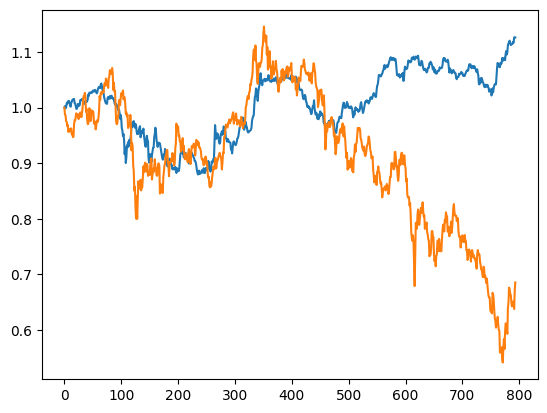

In [16]:
plt.plot(returns)
plt.plot(hsi_return)